# General Dependencies

In [103]:
! pip install keras_ocr
! nvidia-smi
! pip install diffusers==0.8.0 transformers ftfy accelerate # Had to change form 0.3.0 -> 0.8.0
! pip install -qq "ipywidgets>=7,<8"
! pip install transformers

Thu Sep 14 11:42:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |  14905MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [104]:
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image

# DONUT (Text Extraction)
from transformers import DonutProcessor, VisionEncoderDecoderModel, set_seed
import torch

# Autoencoder/KNN (Year/Genre Prediction)
import pickle
import tensorflow as tf
from tensorflow.keras import models

# OCR (Text Location)
import cv2
import keras_ocr
import math
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw
from difflib import SequenceMatcher

# Stable Diffusion (mage2Image pipeline)
import inspect
import random
from typing import List, Optional, Union
import torch
from torch import autocast
from tqdm.auto import tqdm
import warnings

from diffusers import StableDiffusionImg2ImgPipeline


### Google Drive Setup

In [417]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


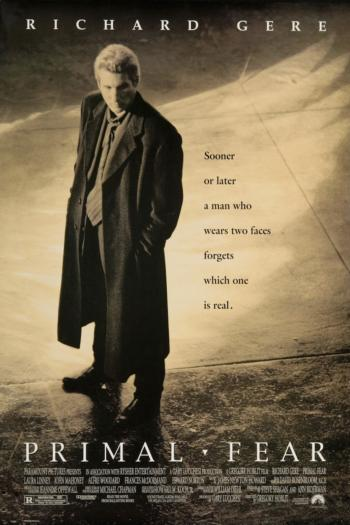

In [437]:
# define paths
base_path = Path("/content/drive/MyDrive/Colab Notebooks/movie_project")
image = base_path / "movies_big_resized/tt0117381.jpg"

# Select Image to open
image = Image.open(image)
image

# Donut (Extracting Text from Image)

In [438]:
#INITIALIZE SEED
set_seed(42)

In [439]:
cache_dir = base_path
processor_path = base_path / "python_files/models/donut_processor"
model_path = base_path / "python_files/models/donut_model"

In [440]:
def initialize_processor():
    # SPECIAL TOKENS
    processor = DonutProcessor.from_pretrained(processor_path, local_files_only=True, cache_dir=cache_dir)
    return processor

In [441]:
def load_model():
    # LOAD MODEL
    model = VisionEncoderDecoderModel.from_pretrained(model_path, local_files_only=True, cache_dir=cache_dir)
    return model

In [442]:
def run_prediction(sample, model, processor):
    # prepare inputs
    pixel_values = processor(sample, random_padding=True, return_tensors="pt").pixel_values

    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # asign device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model.to(device)

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        # early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    return prediction

In [443]:
# LOAD PROCESSOR AND MODEL
processor = initialize_processor()
model = load_model()

In [444]:
prediction = run_prediction(image, model, processor)
prediction

{'Title': 'Primal Fear',
 'Actors': ['Richard Gere', 'Laura Linney', 'Edward Norton']}

In [445]:
# this will be Donut
title = prediction["Title"]
actors = " ".join(prediction["Actors"])

In [446]:
print(title)
print(actors)

Primal Fear
Richard Gere Laura Linney Edward Norton


# Predict Year and Genre (Autoencoder+KNN)

### Dependencies

In [447]:
# Set up paths to models
KNN_MODEL_YEAR_PATH = base_path / "python_files/models/knnpickle_years"
KNN_MODEL_GNERE_PATH = base_path / "python_files/models/knnpickle_genre"
AUTOENCODER = base_path / "python_files/models/autoencoder"
KNN_GENRE = base_path / "python_files/models/genre_predict.npy"

GENRES = [
  'Family',
  'Action',
  'Comedy',
  'Thriller',
  'Romance',
  'Crime',
  'Sci-Fi',
  'Drama'
]

### Functions

In [448]:
def get_genres(indices):
  return [GENRES[i] for i in indices]

In [449]:
def build_multihot(indices, size=8):
  a = np.zeros((8,))
  a[indices] = 1
  return a

In [450]:
def predict_genres(new_X, n_genres, knn, y_genres_ref):
  X = new_X if new_X.ndim == 2 else new_X.reshape(1, -1) # if it's a single obs, reshape to fit sklearn model
  _, indices = knn.kneighbors(X)
  # given their indices, goes grabbing them
  neighbors_labels = y_genres_ref[indices] # axis 0, 1, 2: 0->each tested poster; 1->its neighbors; 2->genres

  # for each tested poster, the sum of genres of its neighbors
  neighbors_added_genres = neighbors_labels.sum(axis=1)
  genres_indices = np.argpartition(neighbors_added_genres, -n_genres)[:, -n_genres:]
  return genres_indices


In [451]:
# Embed images using encoder
def embed_images(image):
    #Load encoder
    autoencoder = models.load_model(AUTOENCODER)
    encoder = autoencoder.get_layer('encoder')

    img_np = np.expand_dims(image, axis=0)
    img_np = img_np.astype('float32') / 255.0
    img_tf = tf.convert_to_tensor(img_np)
    img_resized = tf.image.resize(img_tf, (528, 352))
    image_embeddings = encoder.predict(img_resized)
    img_emb = image_embeddings[0]
    return img_emb


In [452]:
def predict_year(image):
    knn_model_year = pickle.load(open(KNN_MODEL_YEAR_PATH, 'rb'))
    image = embed_images(image)
    X = image if image.ndim == 2 else image.reshape(1, -1) # if it's a single obs, reshape to fit sklearn model

    return knn_model_year.predict(X)

In [453]:
def predict_genre(image):
    knn_model_genre = pickle.load(open(KNN_MODEL_GNERE_PATH, 'rb'))
    yg_train = np.load(KNN_GENRE)
    image = embed_images(image)
    indices = predict_genres(image, 2, knn_model_genre, yg_train)[0]
    return get_genres(indices)

In [454]:
year = round(predict_year(image)[0]/10)*10
genre= ", ".join(predict_genre(image))

print("Predicted Year :", year)
print("Predicted Genre:", genre)

1/1 [==============================] - 0s 258ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator NearestNeighbors from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


1/1 [==============================] - 0s 64ms/step
Predicted Year : 2000
Predicted Genre: Comedy, Drama


# Preparing the Poster (OCR)

### Dependencies

In [455]:
# Keras OCR pipeline
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


### Code

In [456]:
# Find midpoints of bbox
def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2) / 2)
    y_mid = int((y1 + y2) / 2)
    return (x_mid, y_mid)

In [457]:
"""Take in an image, locate text, make df of text locations,
    make new image without the text"""
def process_image_and_inpaint(image, pipeline):
    image = image.resize((352, 528))
    img = np.asarray(image)

    prediction_groups = pipeline.recognize([img])

    texts = []
    bboxes = []
    # Create df of text locations (bbox)
    for result in prediction_groups[0]:
        texts.append(result[0])
        bboxes.append(result[1])

    text_df = pd.DataFrame({'text': texts, 'bbox': bboxes})

    # Create new image with text removed
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1]
        x2, y2 = box[1][2]
        x3, y3 = box[1][3]

        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mid1 = midpoint(x0, y0, x3, y3)

        thickness = int(math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2))

        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mid1), 255, thickness)

        inpainted_img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)

    return text_df, inpainted_img

In [458]:
# Find if two words are similar with a given ratio
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [459]:
# Convert np array back to image
def np_to_img(np_image):
    img = Image.fromarray(np_image, "RGB")
    # Resize image as Stable Diffusion needs an image %8, Org:525, 350
    img = img.resize((352, 528))
    return img

In [460]:
def words_location(text, text_df):
    text_list = text.lower().split()
    bbox_text = []

    for text_word in text_list:
        if text_word in list(text_df.text):
            bbox_text.append([np.floor(x) for x in text_df[text_df.text == text_word].bbox][0])
        else :
            for word in list(text_df.text):
                if similar(text_word,word) > .75:
                    bbox_text.append([np.floor(x) for x in text_df[text_df.text == word].bbox][0])

    return text_list, bbox_text

1/1 [==============================] - 3s 3s/step


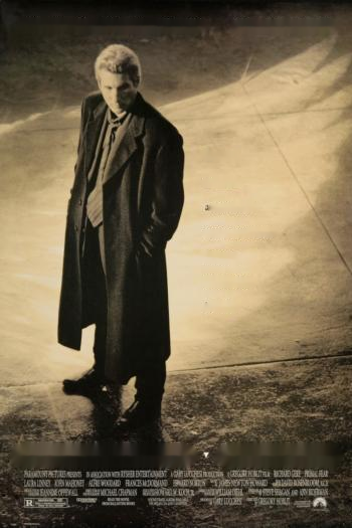

In [461]:
def remove_text(image, title, actors, pipeline=pipeline):

    # Get df of text locations and image without text
    text_df, img_text_removed = process_image_and_inpaint(image, pipeline)

    # Image is in numpy format, convert
    image = np_to_img(img_text_removed)

    # Get words and locaions of Title and Actors
    title_words, title_location = words_location(title, text_df)
    actor_words, actor_location = words_location(actors, text_df)

    return image, title_words, title_location, actor_words, actor_location

image_no_text, tw, tl, aw, al = remove_text(image, title, actors)
image_no_text

# What Year/Genre do you want to change your poster to?

In [462]:
# Genre, Choose between :
# Drama, Comedy, Romance, Action, Thriller, Sci-Fi, Crime, Family
genre = "Action"
# Year, Choose between:
# 1930, 1950, 1970, 1980, 1990, 2000, 2020, 2040
decade = "2000"

# Stable Diffusion

### Load the pipeline

In [463]:
device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    revision="fp16",
    torch_dtype=torch.float16,
    use_auth_token=False
)
pipe = pipe.to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


### Prompt words that will give extra infomation for the generator to follow

In [464]:
genre_buzz_words = {
    "Drama": ["Emotional", "Intense", "Heartfelt", "Character-driven"],
    "Comedy": ["Hilarious", "Lighthearted", "Witty", "Feel-good"],
    "Romance": ["Passionate", "Love story", "Sweeping", "Chemistry", "Epic"],
    "Action": ["Explosive", "Adrenaline", "High-octane", "Heroic", "Thrilling"],
    "Thriller": ["Suspense", "Mystery", "Tension", "Intrigue", "Edge-of-your-seat"],
    "Sci-Fi": ["Futuristic", "Otherworldly", "Space adventure", "Technology"],
    "Crime": ["Criminal", "Investigation", "Noir", "Mystery", "Detective"],
    "Family": ["Wholesome", "All-ages", "playfull", "Charming", "Family-friendly"]
}

genre_visual_features = {
    "Drama": ["Emotional characters", "Subdued color palette", "Expressive lighting", "Symbolic imagery"],
    "Comedy": [ "Bright and cheerful colors", "Comic illustrations", "Visual gags"],
    "Romance": [ "Soft focus", "Warm color schemes", "Intimate moments", "Heart-shaped elements"],
    "Action": ["Explosions and action sequences", "Dynamic composition", "High-contrast visuals", "Heroic poses", "Epic scale"],
    "Thriller": ["Dark and moody lighting", "Mysterious atmosphere", "Intriguing silhouettes", "Foreboding shadows", "Tense expressions"],
    "Sci-Fi": ["Futuristic technology", "Space and otherworldly landscapes", "Sleek and modern designs", "Alien creatures", "Cyberpunk aesthetics"],
    "Crime": ["Noir style", "Detective with a magnifying glass", "Mysterious alleys", "Gritty urban settings", "Crime scene details"],
    "Family": ["Colorful and friendly setting", "Simple and playful designs", "All-ages appeal" ]
}

genre_character_appearance = {
    "Drama": [ "Natural and relatable appearance", "Subtle gestures", "Character depth"],
    "Comedy": ["Playful and humorous appearance", "Comic attire", "Silly or goofy expressions"],
    "Romance": ["Dreamy and in love expressions", "Beautiful and attractive appearance", "Sensual poses"],
    "Action": ["Determined and heroic expressions", "Confident and ready-for-action appearance","Worn-out or rugged looks", "Muscular and fit physique", "Dynamic action poses", "Weapons or tools"],
    "Thriller": ["Tense and anxious facial expressions","Worn-out or rugged looks", "Fearful or suspicious looks", "Mysterious appearance with hidden motives", "Close-ups of worried eyes", "Chasing or running scenes"],
    "Sci-Fi": ["Futuristic and non-human appearances", "Alien or robotic characters", "High-tech gadgets and attire", "Astonished or curious expressions", "Space and time travel elements"],
    "Crime": ["Detective-like appearances", "Serious and investigative expressions", "Worn-out or rugged looks", "Mysterious demeanor", "Clues and evidence in the background"],
    "Family": [ "Joyful and wholesome appearance", "Friendly and approachable looks colorful clothes", "All-ages appeal"]
}

In [465]:
decades_info = {
    "1930": {
        "Visual Features": ["Vintage sepia tone", "Art deco design", "Classic typography", "Elegance and glamour", "Ornate borders"],
        "Character Appearance": ["Sophisticated attire", "Elegant hairstyles", "Formal expressions", "Old Hollywood charm", "Elegance and class"],
        "Decade Buzz Words": ["Golden Age", "Nostalgia", "Classic Cinema", "Glamorous", "Vintage"]
    },
    "1950": {
        "Visual Features": ["Technicolor vibrancy", "Retro fonts", "Cinemascope widescreen", "Atomic era aesthetics", "Drive-in movie posters"],
        "Character Appearance": ["Iconic fashion", "Rockabilly style", "Smiles and charm", "Youthful exuberance", "Hollywood stars"],
        "Decade Buzz Words": ["Rock 'n' Roll", "Atomic Age", "Mid-Century Modern", "Innocence", "Rebellion"]
    },
    "1970": {
        "Visual Features": ["Psychedelic colors", "Funky fonts", "Groovy patterns", "Exploitation film style", "Grainy textures"],
        "Character Appearance": ["Bell-bottoms and fringe", "Afros and long hair", "Rebellious expressions", "Counterculture icons", "1970s cool"],
        "Decade Buzz Words": ["Disco Fever", "Peace and Love", "Cult Classics", "Outrageous", "Revolution"]
    },
    "1980": {
        "Visual Features": ["Neon lights", "Sci-Fi aesthetics", "Retro-futuristic designs", "Synthwave-inspired colors", "Pixel art"],
        "Character Appearance": ["80s fashion", "Big hair and bold makeup", "Action hero poses", "Reckless confidence", "Arcade vibes"],
        "Decade Buzz Words": ["Neon Noir", "Cyberpunk", "MTV Generation", "Radical", "Nostalgic"]
    },
    "1990": {
        "Visual Features": ["Colorful gradients", "Digital effects", "Blockbuster fonts", "90s tech imagery", "CD case style"],
        "Character Appearance": ["90s fashion trends", "Youthful and carefree", "Generation X attitudes", "Pop culture references", "Iconic sitcom smiles"],
        "Decade Buzz Words": ["Generation X", "Dot-com Bubble", "Y2K", "Fresh", "Nostalgia"]
    },
    "2000": {
        "Visual Features": ["Sleek and glossy designs", "Matrix-style green tint", "Metallic accents", "High-tech gadgets", "DVD cover aesthetics"],
        "Character Appearance": ["Y2K fashion", "Matrix-inspired attire", "Action hero expressions", "Tech-savvy look", "Cyberpunk vibes"],
        "Decade Buzz Words": ["Digital Revolution", "Y2K Panic", "New Millennium", "Futuristic", "Cutting-Edge"]
    },
    "2020": {
        "Visual Features": ["Minimalist design", "Flat and clean aesthetics", "Social media-inspired visuals", "Streaming platform style", "App-like icons"],
        "Character Appearance": ["Contemporary attire", "Diverse representation"],
        "Decade Buzz Words": ["Digital Age", "Virtual Reality",]
    },
    "2040": {
        "Visual Features": ["Advanced holographics", "Biotech aesthetics", "Cybernetic designs", "Immersive VR experiences", "Futuristic cityscapes"],
        "Character Appearance": ["Enhanced cybernetic features", "Augmented reality attire", "Expressive through AI", "Transhumanist ideals", "Futuristic beauty"],
        "Decade Buzz Words": ["Post-Human", "AI Dominance", "Tech Utopia", "Cybernetic Evolution", "Sustainable"]
    }
}

### Making the prompt

In [489]:
# Using random.sample() to create different prompts everytime
# Get the buzz words, visual features, and character appearance for Drama genre
buzz_words = random.sample(genre_buzz_words[genre], 2)
visual_features = random.sample(genre_visual_features[genre], 2)
character_appearance = random.sample(genre_character_appearance[genre], 2)

# Get the visual features, character appearance, and decade buzz words for the year 1950
decade_visual_features = random.sample(decades_info[decade]["Visual Features"], 2)
decade_character_appearance = random.sample(decades_info[decade]["Character Appearance"], 2)
decade_buzz_words = random.sample(decades_info[decade]["Decade Buzz Words"], 2)

# Create a prompt using the gathered information
prompt = f"Remove text, Create a {genre} scene that embodies the {decade} era. Make it {', '.join(buzz_words)} with {', '.join(visual_features)} elements. same numbers of people from original picture, character appearance: {', '.join(character_appearance)}. Capture spirit of {', '.join(decade_buzz_words)}. {title}"
negative_prompt = "(((text))), (((title))), (words), (letters), ((Characters)), ((numbers)),((unclear face)), ((((ugly)))), (((duplicate))), ((morbid)), ((mutilated)), out of frame, (((poorly drawn face))), ((unclear face)), (((mutation))), (((deformed))), ((ugly)), blurry, ((bad anatomy)), (((bad proportions))), ((extra limbs)), cloned face, (((disfigured))), (bad anatomy), gross proportions, (malformed limbs), ((missing arms)), ((missing legs)), (((extra arms))), (((extra legs))), (((long neck))), ((fuzzy face)), (((hazy facial features)))"

### Putting the prompt through the generator

  0%|          | 0/31 [00:00<?, ?it/s]

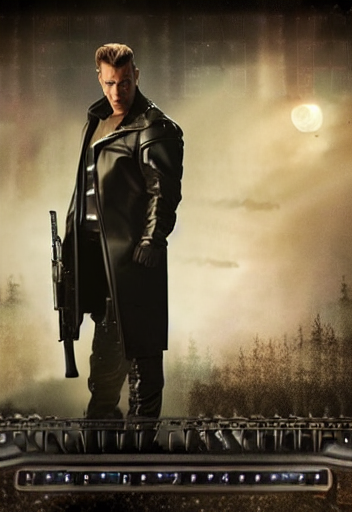

In [490]:
device = 'cuda'

generator = torch.Generator(device=device).manual_seed(1024)
with autocast("cuda"):
    image = pipe(prompt=prompt, negative_prompt=negative_prompt, init_image=image_no_text, strength=.6, guidance_scale=7.5, generator=generator).images[0]

image

# Final Image Processing (Reintroduce the text)

In [491]:
# Put the words back on the image in the same place they were before
def print_words(image, text_list, bbox_text, font_style):

    draw = ImageDraw.Draw(image)

    # Making sure the colour is different from the background
    # Select first bbox of first word
    box = bbox_text[0]
    cor_left = min(np.floor(box[0][0]), np.floor(box[2][0]))
    cor_upper= min(np.floor(box[0][1]), np.floor(box[2][1]))
    cor_right= max(np.floor(box[0][0]), np.floor(box[2][0]))
    cor_lower= max(np.floor(box[0][1]), np.floor(box[2][1]))
    # Crop where text should be, find most common colour and choose the opposite
    crop_img = image.crop((cor_left, cor_upper, cor_right, cor_lower))
    most_common = sorted(crop_img.getcolors(maxcolors=2**16), key=lambda t: t[0], reverse=True)[0]
    fill=(255-most_common[1][0], 255-most_common[1][1], 255-most_common[1][2])

    for i, bbox in enumerate(bbox_text):
        a, b, = bbox[0]
        text = text_list[i]
        font = ImageFont.truetype(f"/content/drive/MyDrive/Colab Notebooks/movie_project/python_files/fonts/{font_style}.ttf", 1)
        font_len = 0
        font_size = 1

        # Making font bigger until text is the same size as before
        while font_len < (bbox[1][0] - bbox[0][0]):
            font = ImageFont.truetype(f"/content/drive/MyDrive/Colab Notebooks/movie_project/python_files/fonts/{font_style}.ttf", 1+font_size)
            font_size = font_size + 1
            font_len = font.getlength(text)

        font = ImageFont.truetype(f"/content/drive/MyDrive/Colab Notebooks/movie_project/python_files/fonts/{font_style}.ttf", font_size-1)
        draw.text((a, b), text=text, font=font , fill=fill)

    return image


In [492]:
def add_text(image, title_words, title_location, actor_words, actor_location):

    # Choose font style #TODO: change to Drama, Comedy...
    font_style = ["LuckiestGuy", "Mistral", "Serpentine"]

    # Put text for Title and Actors on the image
    print_words(image, title_words, title_location, font_style[0])
    print_words(image, actor_words, actor_location, font_style[0])

    return image

In [493]:
poster_final = add_text(image, tw, tl, aw, al)

# Here is your new movie poster

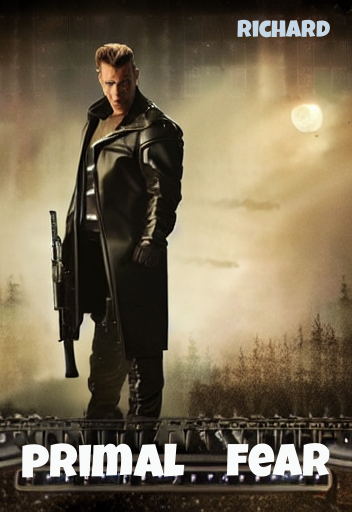

In [494]:
poster_final